# LEV / GSW overlay

Various methods for overlaying emergent lake vegetation rasters over Pekel/GSW inundation rasters. Occurrence seems to perform better than Seasonality.

In [1]:
## Imports
import os
import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm
from scipy.stats import binned_statistic
import seaborn as sns
from tqdm import tqdm
import numpy as np
import pandas as pd

In [2]:
## Env vars
reclass_vals_detailed = {
    1:	'dry land',
    2:	'water',
    3:	'wet graminoid',
    4:	'wet shrubs',
    5:	'wet forest',
    25: 'river or bridge',
    30: 'urban',
    35: 'non-roi',
    42:	'water no lake',
    43:	'wet graminoid no lake',
    44: 'wet shrubs no lake',
    45: 'wet forest no lake',
    52: 'water not valid'}

reclass_vals_simple = {
    1:	'dry land',
    2:	'water',
    3:	'LEV',
    4:	'LEV',
    5:	'LEV',
    25: 'invalid', 
    30: 'invalid', 
    35: 'non-roi', 
    42:	'invalid', 
    43:	'invalid', 
    44: 'invalid', 
    45: 'invalid', 
    52: 'invalid'}

## Method A: Load from GIS operations
In QGIS:
1. Polygonize burned UAVSAR raster
2. Zonal histogram based on DN field

In Python:
1. Aggregate by class
2. Compute confusion matrix and plot histograms

In [3]:
## I/O
region = 'YF'
df_pth = '/mnt/g/Ch4/misc/UAVSAR_polygonized/sub_roi/zonal_hist/YFLATS_190914_mosaic_rcls_brn_zHist_Oc.shp' # this is zonal histogram of YF UAVSAR against GSW Occurrence
# region = 'CSB'
# df_pth = '/mnt/g/Ch4/misc/UAVSAR_polygonized/sub_roi/zonal_hist/bakerc_16008_19059_012_190904_L090_CX_01_Freeman-inc_rcls_brn_zHist_Oc.shp'
# region = 'PAD'
# df_pth = '/mnt/g/Ch4/misc/UAVSAR_polygonized/sub_roi/zonal_hist/padelE_36000_19059_003_190904_L090_CX_01_Freeman-inc_rcls_brn_zHist_Oc.shp'
# region = 'CSD'
# df_pth = '/mnt/g/Ch4/misc/UAVSAR_polygonized/sub_roi/zonal_hist/daring_21405_17094_010_170909_L090_CX_01_LUT-Freeman_rcls_brn_zHist_Oc.shp'

## Outputs
overlay_pth = os.path.join(os.path.dirname(df_pth), 'LEV_GSW_overlay', os.path.basename(df_pth).replace('.shp', '_LEV.csv'))## Load
overlay_pth_s = os.path.join(os.path.dirname(df_pth), 'LEV_GSW_overlay', os.path.basename(df_pth).replace('.shp', '_LEV_s.csv'))## Load

df = gpd.read_file(df_pth, engine='pyogrio') 
df.head()

,DN,HISTO_0,HISTO_1,HISTO_2,HISTO_3,HISTO_4,HISTO_5,HISTO_6,HISTO_7,HISTO_8,...,HISTO_92,HISTO_93,HISTO_94,HISTO_95,HISTO_96,HISTO_97,HISTO_98,HISTO_99,HISTO_100,geometry
0,35,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-1975508.149 3758374.790, -1975479.9..."
1,35,123.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-1976801.208 3757285.006, -1976772.9..."
2,35,402.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-1976355.131 3757951.299, -1976332.5..."
3,35,83.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-1977840.173 3754744.059, -1977817.5..."
4,35,1336.0,2.0,1.0,2.0,1.0,0.0,1.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-1976117.976 3755935.481, -1976089.7..."


In [4]:
## Add actual class name
df['Class'] = df['DN'].apply(lambda x: reclass_vals_detailed[x])
df['Broad_class'] = df['DN'].apply(lambda x: reclass_vals_simple[x])

In [5]:
# Aggregate by class (detailed)
dfg = df.groupby('Class')
df_sums = dfg.sum(numeric_only=True)
df_sums.drop(columns='DN', inplace=True) # drop meaningless columns
df_sums.loc['SUM', :]=df_sums.sum()

# Aggregate by class (simple)
dfgs = df.groupby('Broad_class')
df_sums_s = dfgs.sum(numeric_only=True)
df_sums_s.drop(columns='DN', inplace=True)
df_sums_s.drop(index='non-roi', inplace=True)
df_sums_s.loc['SUM', :]=df_sums_s.sum() # don't include out of ROI samples, obviously


## Save array
# df_sums.to_csv(overlay_pth)
# df_sums_s.to_csv(overlay_pth_s)

## View
df_sums_s

,HISTO_0,HISTO_1,HISTO_2,HISTO_3,HISTO_4,HISTO_5,HISTO_6,HISTO_7,HISTO_8,HISTO_9,...,HISTO_91,HISTO_92,HISTO_93,HISTO_94,HISTO_95,HISTO_96,HISTO_97,HISTO_98,HISTO_99,HISTO_100
Broad_class,,,,,,,,,,,,,,,,,,,,,
LEV,162624.0,1219.0,2347.0,2643.0,2275.0,1920.0,1895.0,1635.0,1516.0,1462.0,...,298.0,251.0,167.0,84.0,48.0,45.0,57.0,68.0,5.0,0.0
dry land,4913459.0,4638.0,7189.0,6844.0,5055.0,3701.0,3086.0,2741.0,2484.0,2421.0,...,491.0,493.0,513.0,471.0,690.0,1015.0,2076.0,2538.0,460.0,4.0
invalid,503535.0,2245.0,3545.0,3349.0,2415.0,1920.0,1517.0,1381.0,1394.0,1359.0,...,3578.0,4755.0,6371.0,7937.0,7503.0,9233.0,20803.0,33941.0,7719.0,25.0
water,128087.0,1186.0,2547.0,2467.0,1882.0,1685.0,1524.0,1391.0,1466.0,1379.0,...,15429.0,16441.0,15927.0,10996.0,4679.0,1954.0,5095.0,7415.0,1227.0,12.0
SUM,5707705.0,9288.0,15628.0,15303.0,11627.0,9226.0,8022.0,7148.0,6860.0,6621.0,...,19796.0,21940.0,22978.0,19488.0,12920.0,12247.0,28031.0,43962.0,9411.0,41.0


In [6]:
## Compute mean LEV, regardless of Occurrence
sums = df_sums_s.sum(axis=1)
sums.LEV / (sums.LEV + sums['dry land'] + sums.water)

0.04260514942960477

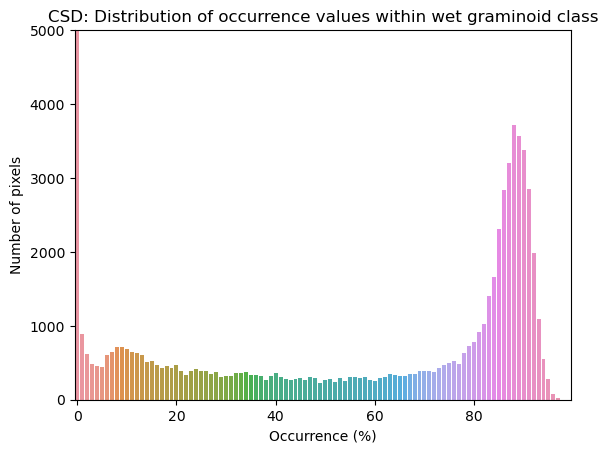

In [6]:
## Plot hist to show: "Within all wet graminoid pixels, what was the distribution of occurrence values"
'''Almost all WG pixels have 0 occurrence...'''
hist_wg = df_sums.loc['wet graminoid', 'HISTO_0':] # 'HISTO_100'
sns.barplot(x=np.arange(df_sums.columns.size), y=hist_wg)
plt.ylim([0, 5000])
plt.xticks(ticks=plt.xticks()[0][::20])
plt.xlabel('Occurrence (%)')
plt.ylabel('Number of pixels')
plt.title(f'{region}: Distribution of occurrence values within wet graminoid class')
plt.show()

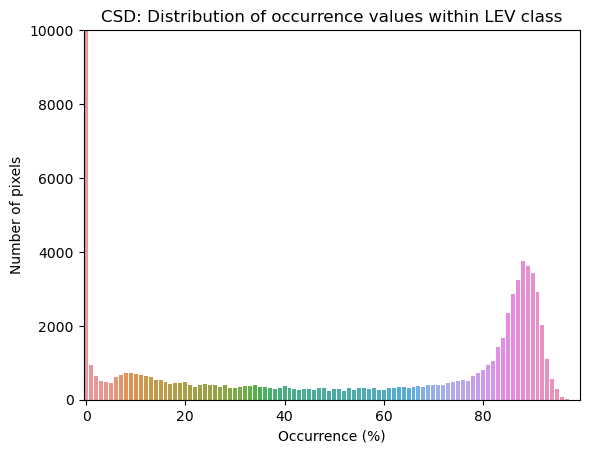

In [7]:
## Plot hist to show: "Within all LEV, what was the distribution of occurrence values"
'''Almost all WG pixels have 0 occurrence...'''
hist_wg = df_sums_s.loc['LEV', 'HISTO_0':]
sns.barplot(x=np.arange(df_sums.columns.size), y=hist_wg)
plt.ylim([0, 10000]) #5,000 for most sites, 10,000 for PAD
plt.xticks(ticks=plt.xticks()[0][::20])
plt.xlabel('Occurrence (%)')
plt.ylabel('Number of pixels')
plt.title(f'{region}: Distribution of occurrence values within LEV class')
plt.show()

### Now, group occurrence and calculate confusion matrix

In [8]:
## Compute binned statistic
stats_classes = ['LEV', 'dry land', 'water', 'SUM'] # 
bStat = binned_statistic(np.arange(df_sums_s.columns.size), values=df_sums_s.loc[stats_classes, :], statistic='sum', bins=[0, 5, 50, 95, 100]) # 
df_sums_s
bStat


BinnedStatisticResult(statistic=array([[9.008300e+04, 1.900800e+04, 4.296400e+04, 3.780000e+02],
       [6.322170e+06, 1.223260e+05, 3.060240e+05, 4.168000e+03],
       [3.100710e+05, 7.807700e+04, 1.856505e+06, 1.704360e+05],
       [6.857317e+06, 2.260500e+05, 2.223839e+06, 1.752870e+05]]), bin_edges=array([  0.,   5.,  50.,  95., 100.]), binnumber=array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4]))

In [9]:
## Construct Confusion Matrix

cm = pd.DataFrame(bStat.statistic[[0, -1]], columns = bStat.bin_edges[1:], index = [stats_classes[0], stats_classes[-1]])
cm.loc['Other', :] = cm.loc['SUM',:] - cm.loc['LEV', :] # this will return an error if the row order or names changes
cm = cm.reindex(cm.index[[0,2,1]])
cm

## Construct Confusion Matrix with water
cm_full = pd.DataFrame(bStat.statistic, columns = bStat.bin_edges[1:], index = stats_classes)
cm_full.loc['Other', :] = cm_full.loc['SUM',:] - cm_full.loc[stats_classes[:3], :].sum()
cm_full = cm_full.reindex(cm_full.index[[0,1,2,4,3]])
cm_full

,5.0,50.0,95.0,100.0
LEV,90083.0,19008.0,42964.0,378.0
dry land,6322170.0,122326.0,306024.0,4168.0
water,310071.0,78077.0,1856505.0,170436.0
Other,134993.0,6639.0,18346.0,305.0
SUM,6857317.0,226050.0,2223839.0,175287.0


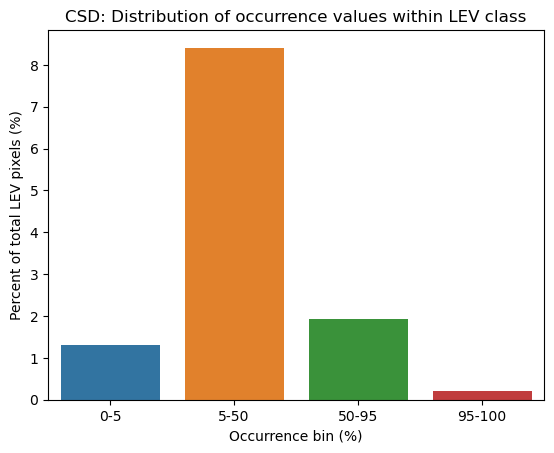

In [10]:
## Plot binned stat
## Plot hist to show: "Within all LEV, what was the binned distribution of occurrence values (normalized by total pixels in each LEV bin, so values don't sum to 100)?"
'''Almost all WG pixels have 0 occurrence...'''
bin_labels = ['0-5', '5-50', '50-95', '95-100']
sns.barplot(x=cm.columns, y=cm.loc['LEV', :] / cm.loc['SUM', :] * 100)

# plt.ylim([0, 5000])
plt.xticks(ticks=plt.xticks()[0][::20])
plt.xlabel('Occurrence bin (%)')
plt.xticks(ticks=np.arange(4), labels = bin_labels)
plt.ylabel('Percent of total LEV pixels (%)')
plt.title(f'{region}: Distribution of occurrence values within LEV class')
plt.show()



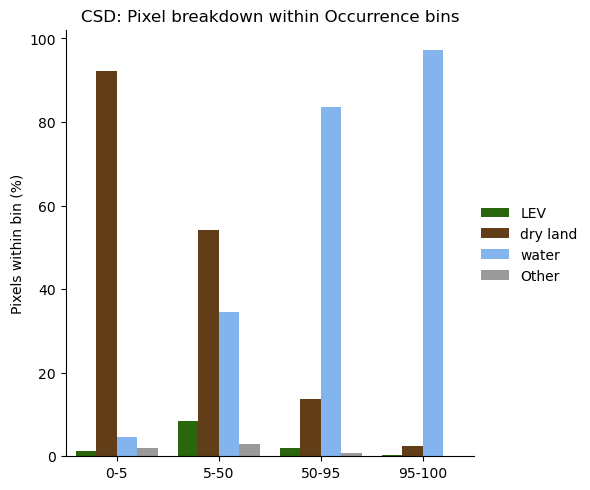

In [11]:
## Plot binned stat for all main classes as percentage of total pixels in bin (reshape first with pd.melt). Normalization is same as above plot, so each group sums to 100.
g = sns.catplot((cm_full.drop('SUM')/ cm_full.loc['SUM', :] * 100).reset_index().melt(id_vars='index', var_name='bin_R_edge'),\
     x = 'bin_R_edge', y='value', hue='index', kind='bar', palette=['#267300', '#6d3f0b', '#73b2ff', '#9a9a9a']) #
g.legend.set_title('')
g.set_axis_labels('', 'Pixels within bin (%)')
g.set(title=f'{region}: Pixel breakdown within Occurrence bins', xticklabels=bin_labels)

### Bar plots grouped and normalized the opposite way

In [12]:
## Add sum column
cm_full.columns = cm_full.columns.astype('str')
cm_full['ROWSUM'] = cm_full.sum(axis='columns')

# Rename labels
cm_full.columns=bin_labels + ['ROWSUM']

## Normalize by dividing row by sum
cm_full_rowNorm = pd.DataFrame(cm_full.values / cm_full.loc[:,'ROWSUM':].values * 100, index=cm_full.index, columns=cm_full.columns)# .drop('SUM')
cm_full_rowNorm

,0-5,5-50,50-95,95-100,ROWSUM
LEV,59.096784,12.469741,28.185498,0.247978,100.0
dry land,93.596773,1.810979,4.530542,0.061705,100.0
water,12.838906,3.232883,76.871080,7.057131,100.0
Other,84.221658,4.142049,11.446005,0.190288,100.0
SUM,72.315550,2.383867,23.452050,1.848533,100.0


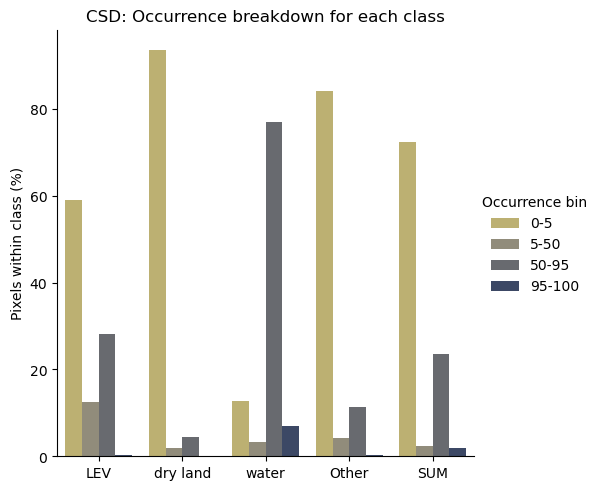

In [13]:
## Reshape (melt) and plot as grouped bar plot
"Within all of one occurrence bin, what was the contribution of LEV values"
g = sns.catplot(cm_full_rowNorm.drop(columns='ROWSUM').reset_index().melt(id_vars='index', var_name='Occurrence bin'),\
     hue = 'Occurrence bin', y='value', x='index', kind='bar', palette='cividis_r')
g.set_axis_labels('', 'Pixels within class (%)')
g.set(title=f'{region}: Occurrence breakdown for each class')

### Try to visualize confusion matrix

In [2]:
cm.iloc[:2, :-1]

NameError: name 'cm' is not defined

KeyError: (0, 0)

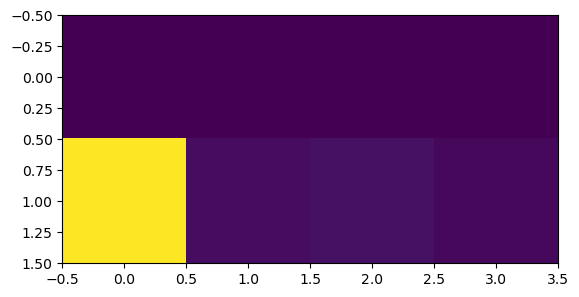

In [130]:
## Visualize CM
from sklearn.metrics import ConfusionMatrixDisplay
cmD = ConfusionMatrixDisplay(cm.iloc[:2, :])
# cmD.
cmD.plot()

### CM viz V2

In [152]:
## Add row sum
# cm.columns = ['0-5', '5-50', '50-95', '95-100'] # comment out if already run
# cm['SUM'] = cm.sum(axis=1)
cm.astype('int')

,0-5,5-50,50-95,95-100,SUM
LEV,171108,57047,14811,223,243189
SUM,50507184,1657152,2227264,1062964,55454564
Other,50336076,1600105,2212453,1062741,55211375


KeyError: (0, 0)

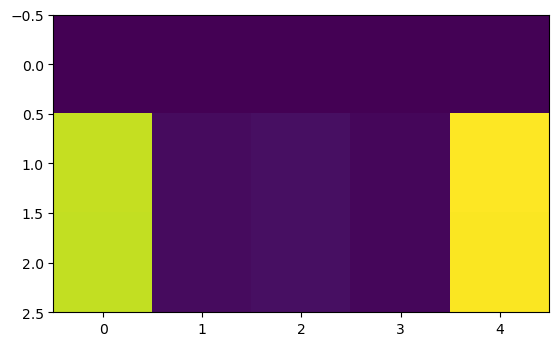

In [148]:
cmD = ConfusionMatrixDisplay(cm)
# cmD = ConfusionMatrixDisplay(cm.iloc[:2, :4])
# cmD.
cmD.plot()

## Method B: Load from lengthy GIS operations
In QGIS:
1. Polygonize burned UAVSAR raster
2. Dissolve based on DN field to get only n entries corresponding to n classes
2. Zonal histogram based on DN field

In [30]:
## Load file that has already been aggregated through verrry slow QGIS dissolve by DN
df = gpd.read_file('/mnt/g/Ch4/misc/UAVSAR_polygonized/sub_roi/dissolved/zonal_hist/YFLATS_190914_mosaic_rcls_brn_ds_Occurrence.shp')
df.head()

,DN,geometry
0,35,"MULTIPOLYGON (((-2017546.705 3712282.011, -201..."
1,5,"MULTIPOLYGON (((-2034859.024 3717013.819, -203..."
2,4,"MULTIPOLYGON (((-2057236.298 3723637.221, -205..."
3,3,"MULTIPOLYGON (((-2058766.512 3723947.781, -205..."
4,2,"MULTIPOLYGON (((-2059381.986 3723834.850, -205..."
